# Three Channel Correlation Method

Text(0.5, 0, 'Frequency (Hz)')

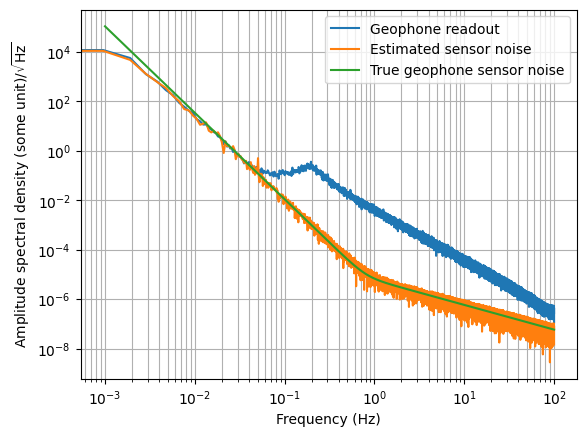

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy

import kontrol


# Generate measurements
# Geophone noise spectrum (micron/sqrt(Hz))
f = np.linspace(1e-3, 1e2, 1024*512)
def noise_model(f, na, nb, a, b):
    return np.sqrt((na/f**a)**2 + (nb/f**b)**2)
n_geophone = noise_model(f, na=1*10**-5.46, nb=1*10**-5.23, a=3.5, b=1)
n_relative = noise_model(f, na=1*10**-2.07, nb=1*10**-2.3, a=0.5, b=0)

# Ground motion
s = control.tf("s")
wn = 0.2*2*np.pi  # Secondary microseism
q = 2.5  # 10 times height
ground_motion_tf = 0.1 * wn**2 / (s**2+wn/q*s+wn**2)

# Generate time series measurements
np.random.seed(1)
t, geophone_noise1 = kontrol.spectral.asd2ts(n_geophone, f=f)
_, geophone_noise2 = kontrol.spectral.asd2ts(n_geophone, f=f)
_, geophone_noise3 = kontrol.spectral.asd2ts(n_geophone, f=f)
_, relative_noise = kontrol.spectral.asd2ts(n_relative, f=f)

# Ground motion
fs = 1/(t[1]-t[0])
u = np.random.normal(loc=0, scale=np.sqrt(fs/2), size=len(t))
_, ground_motion = control.forced_response(ground_motion_tf, U=u, T=t)

# 3 geophone measurements
readout1 = ground_motion + geophone_noise1
readout2 = ground_motion + geophone_noise2
readout3 = ground_motion + geophone_noise3
readout_relative = relative_noise

# Obtain the measured spectral densities.
fs = 1/(t[1]-t[0])
f_, p11 = scipy.signal.welch(readout1, fs=fs, nperseg=int(len(t)/5))
f_, p22 = scipy.signal.welch(readout2, fs=fs, nperseg=int(len(t)/5))
f_, p33 = scipy.signal.welch(readout3, fs=fs, nperseg=int(len(t)/5))
f_, noise_relative = scipy.signal.welch(readout_relative, fs=fs, nperseg=int(len(t)/5))

_, p12 = scipy.signal.csd(readout1, readout2, fs=fs, nperseg=int(len(t)/5))
_, p13 = scipy.signal.csd(readout1, readout3, fs=fs, nperseg=int(len(t)/5))
_, p21 = scipy.signal.csd(readout2, readout1, fs=fs, nperseg=int(len(t)/5))
_, p23 = scipy.signal.csd(readout2, readout3, fs=fs, nperseg=int(len(t)/5))
_, p31 = scipy.signal.csd(readout3, readout1, fs=fs, nperseg=int(len(t)/5))
_, p32 = scipy.signal.csd(readout3, readout2, fs=fs, nperseg=int(len(t)/5))
# ^Measurement data generated.

# Estimate the sensor nosie using three channel correlation method
noise1, noise2, noise3 = kontrol.spectral.three_channel_correlation(
    p11, psd2=p22, psd3=p33, csd12=p12, csd13=p13, csd21=p21, csd23=p23, csd31=p31, csd32=p32)

plt.loglog(f_, p11**0.5, label="Geophone readout")
plt.loglog(f_, noise1**0.5, label="Estimated sensor noise")
# plt.loglog(f_, noise_relative**0.5, label="Relative sensor noise")
plt.loglog(f, n_geophone, label="True geophone sensor noise")
# plt.loglog(f, n_relative, label="Relative")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

In [2]:
# Export the noises
import pickle

with open("noise_spectrum_inertial.pkl", "wb") as fh:
    pickle.dump(noise1**0.5, fh)
with open("noise_spectrum_relative.pkl", "wb") as fh:
    pickle.dump(noise_relative**0.5, fh)
with open("noise_spectrum_frequency.pkl", "wb") as fh:
    pickle.dump(f_, fh)